In [21]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy
from sklearn.cluster import KMeans
import sklearn.cluster as cl
import itertools
from scipy.spatial import ConvexHull
import scipy.ndimage.filters
import os

In [22]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [57]:
def binarize(img):
    return (np.sign(img-10)+1)/2

In [70]:
xvals = []
yvals = []
vals = []
basedir = 'dataset copy/'
for x in range(2**6):
    a = '{0:b}'.format(x)
    bindir = basedir+(6-len(a))*'0'+a+'/'
    for filename in os.listdir(bindir):
        if filename.endswith(".npy"): 
            filename = os.path.join(bindir, filename)
            if (int(filename[-5])%4==0):
                vals.append((binarize(np.load(filename)), x))
    #print(a)
np.random.shuffle(vals)
xvals = np.array([v[0] for v in vals])
yvals = np.array([v[1] for  v in vals])
xvals = xvals.reshape((xvals.shape[0],1,xvals.shape[1],xvals.shape[2]))
print(xvals.shape)
print(yvals.shape)
validationX = xvals[:1000]
validationY = yvals[:1000]
trainX = xvals[1000:]
trainY = yvals[1000:]

(12914, 1, 46, 72)
(12914,)


0.0


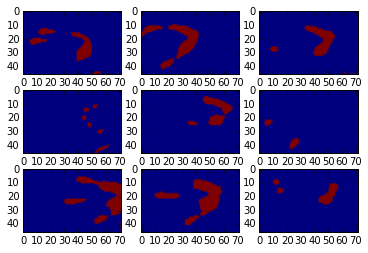

In [68]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(xvals[i,0,:,:])
print(np.min(xvals[0]))
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [36]:
def baseline_model(num_classes):
    # create model
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 46, 72), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [71]:
X_train = trainX.reshape(trainX.shape[0], 1, 46, 72).astype('float32')
X_Val = validationX.reshape(validationX.shape[0], 1, 46, 72).astype('float32')
# flatten 28*28 images to a 784 vector for each image
# one hot encode outputs
y_train = np_utils.to_categorical(trainY)
y_validation = np_utils.to_categorical(validationY)
num_classes = y_train.shape[1]
# build the model
model = baseline_model(num_classes)
print(X_train.shape)
print(y_train.shape)
# Fit the model
try:
    model.fit(X_train, y_train, validation_data=(X_Val, y_validation), nb_epoch=10, batch_size=200, verbose=2)
except KeyboardInterrupt:
    model.save('model.h5')
model.save('model.h5')
scores = model.evaluate(X_Val, y_validation, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
# Final evaluation of the model

(11914, 1, 46, 72)
(11914, 64)
Train on 11914 samples, validate on 1000 samples
Epoch 1/10
54s - loss: 2.3824 - acc: 0.3916 - val_loss: 1.1882 - val_acc: 0.6620
Epoch 2/10
46s - loss: 0.7043 - acc: 0.8127 - val_loss: 0.5933 - val_acc: 0.8460
Epoch 3/10
49s - loss: 0.3504 - acc: 0.9138 - val_loss: 0.4201 - val_acc: 0.8910
Epoch 4/10
51s - loss: 0.2297 - acc: 0.9459 - val_loss: 0.3268 - val_acc: 0.9110
Epoch 5/10
60s - loss: 0.1527 - acc: 0.9689 - val_loss: 0.2606 - val_acc: 0.9410
Epoch 6/10
55s - loss: 0.1090 - acc: 0.9796 - val_loss: 0.2424 - val_acc: 0.9350
Epoch 7/10
53s - loss: 0.0983 - acc: 0.9799 - val_loss: 0.2530 - val_acc: 0.9360
Epoch 8/10
51s - loss: 0.0908 - acc: 0.9810 - val_loss: 0.2456 - val_acc: 0.9300
Epoch 9/10
51s - loss: 0.0952 - acc: 0.9796 - val_loss: 0.2436 - val_acc: 0.9330
Epoch 10/10
48s - loss: 0.0963 - acc: 0.9781 - val_loss: 0.3132 - val_acc: 0.9180
Baseline Error: 8.20%


/home/riku/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


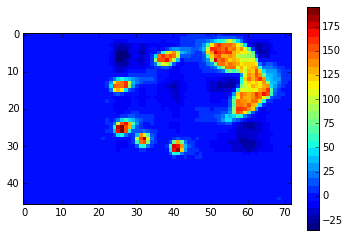

In [376]:
#img = np.load('testclosed.npy')
img = np.load('testclosed.npy')
plt.imshow(img, cm.get_cmap('jet', 30), interpolation='nearest')
plt.colorbar()

(46, 72)


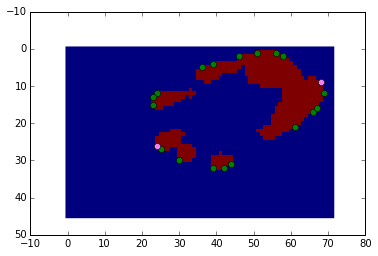

In [377]:
binarized = (np.sign(img-10)+1)/2
plt.imshow(binarized, interpolation='nearest')
print(binarized.shape)

points = []
for y in range(binarized.shape[0]):
    for x in range(binarized.shape[1]):
        if binarized[y,x]==1:
            points.append([y,x])
points = np.array(points)
hull = ConvexHull(points)
vertices = hull.vertices
#print(hull.vertices)
plt.plot(points[hull.vertices,1],points[hull.vertices,0],'o', color='green')
distance = lambda x,y: (x[0]-y[0])**2+(x[1]-y[1])**2
#print(list(itertools.combinations(hull.vertices, 2)))
axis = max(itertools.combinations(hull.vertices, 2), key=lambda x:distance(points[x[0]], points[x[1]]))
plt.plot(points[axis,1],points[axis,0],'o', color='violet')

ward = cl.AgglomerativeClustering(n_clusters=6, linkage='ward').fit(points)
label = ward.labels_

#for l in np.unique(label):
#    plt.plot(points[label == l, 1], points[label == l, 0], 'o', color=plt.cm.jet(np.float(l) / np.max(label + 1)))
#plt.imshow(copy, interpolation='nearest')

In [381]:
def transform(points, axis, d=0.4, orientation = 0):
    pivot = points[axis[1-orientation]]
    pivot1 = points[axis[orientation]]
    perp = [(pivot1-pivot)[1],-(pivot1-pivot)[0]]
    transformed = []
    for point in points:
        if not np.array_equal(point,pivot):
            #transformed.append((np.dot(point-pivot, pivot1-pivot)/np.linalg.norm(pivot1-pivot),
            #                 np.dot(perp, point-pivot)/np.linalg.norm(perp)))
            transformed.append((np.dot(point-pivot, pivot1-pivot)/np.linalg.norm(pivot1-pivot),
                             np.arcsin((np.cross(pivot1-pivot, point-pivot)/np.linalg.norm(pivot1-pivot)/np.linalg.norm(point-pivot)))))
    transformed = np.array(transformed)
    transformed[:,0] = np.divide(transformed[:,0],np.linalg.norm(pivot1-pivot)/(1+d))-d
    transformed = transformed[np.where(transformed[:,0]>0)]
    plt.plot(transformed[:,0],transformed[:,1],'o', color='violet')
    return transformed
def dfs(marked, tree, x, y, points):
    dist, point = tree.query([x*xstep, y*ystep])
    if not close(np.min(dist)) or marked[(y,x)]:
        return 
    else:
        points.append(point)
        marked[(y,x)] = True
        #print(points)
        dfs(marked, tree, x-1,y, points)
        dfs(marked, tree, x+1,y, points)
        dfs(marked, tree, x,y-1, points)
        dfs(marked, tree, x,y+1, points)
        dfs(marked, tree, x-1,y-1, points)
        dfs(marked, tree, x-1,y+1, points)
        dfs(marked, tree, x+1,y-1, points)
        dfs(marked, tree, x+1,y+1, points)
close = lambda dist: dist*dist<xstep*xstep+ystep*ystep
def numFingers(data, xstep=1/20, ystep=1/20):
    mytree = scipy.spatial.cKDTree(data)
    marked = {}
    for y in np.arange(-2/ystep, 2/ystep):
        for x in np.arange(-2/xstep, 2/xstep):
            marked[(y,x)] = False
    close = lambda dist: dist*dist<xstep*xstep+ystep*ystep
    sets = []
    for y in np.arange(-2/ystep, 2/ystep):
        for x in np.arange(-2/xstep, 2/xstep):
            dist, index = mytree.query([x*xstep, y*ystep])
            if not marked[(y,x)] and close(dist):
                testset = []
                dfs(marked, mytree, x,y, testset)
                arr = []
                for p in set(testset):
                    arr.append(data[p,:])
                arr = np.array(arr)
                #if(np.abs(np.correlate(arr[:,0], arr[:,1]))<10):
                sets.append(np.array(arr))
    colors = ['red', 'blue','green', 'purple']
    for x in range(len(sets)):
        #print(sets[x])
        #print(np.correlate(sets[x][:,0], sets[x][:,1]))
        #if (np.abs(np.correlate(sets[x][:,0], sets[x][:,1]))<10):
        plt.plot(sets[x][:,0],sets[x][:,1],'o', color=colors[x%len(colors)])
        #print(len(sets))
    return len(sets)

def numFingers1(data):
    n, bins, patches = plt.hist(scipy.ndimage.filters.gaussian_filter(data1[:,1],1), 40, normed=1, weights= data1[:,0], facecolor='green', alpha=0.75)
    deltas = [n[x+1]-n[x] for x in range(len(n)-1)]
    peaks = [bins[x+1] for x in range(len(deltas)-1) if deltas[x]*-deltas[x+1]>0.05]
    return peaks



9


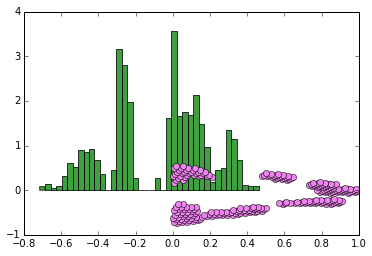

In [382]:
data1 = transform(points, axis, orientation=0)
#data2 = transform(points, axis, orientation=1)
#print(numFingers(data1))
print(len(numFingers1(data2)))

[0.062218856714233495, -0.090008306551025291, 0.045386702240817471, 0.22739803494767297, 0.29467200298915219, -0.096921512852609304, 0.38847847426713145, -0.05298303169472951, 0.071345382029366688, -0.25398518803636438, -0.30169450899510564, -0.36828535388425093, 0.45750123757857442, 2.6896744501327023, -0.35358454364611136, -0.8272894623979512, -1.6994737783670426, -0.2714731407360168, 0.0, 0.0, 0.26305706349930991, -0.26305706349930991, 1.612006689942685, 1.9479393313325783, -1.9043287492878191, 0.08924320862042201, -0.055141700856099263, 0.43137860823346785, -0.63934862072886456, -0.50783375144226761, -0.78641137296251262, 0.25800195217206545, 0.061590383414089733, 0.834530567812651, -0.20357069939439598, -0.45435887107784978, -0.57335892421377854, -0.010082897728393631, -0.0070771558581407545]
[-0.30272105037902025, -0.067044110119452771, -0.0081248750545608317, 0.10971359507522294, 0.19809244767256073]
5


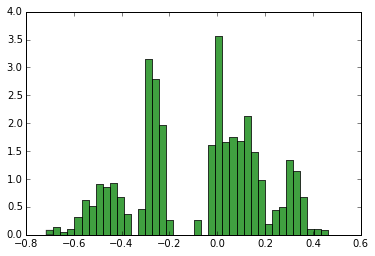

In [390]:
n, bins, patches = plt.hist(scipy.ndimage.filters.gaussian_filter(data1[:,1],1), 40, normed=1, weights= data1[:,0], facecolor='green', alpha=0.75)
deltas = [n[x+1]-n[x] for x in range(len(n)-1)]
peaks = [bins[x+1] for x in range(len(deltas)-1) if deltas[x]*-deltas[x+1]>0.2]
print(deltas)
print(peaks)
print(len(peaks))
#print(peaks)
#plt.plot(peaks, [1,2,1,2])

In [6]:
import ftd2xx as FT
import sys
import numpy as np
crcTable = [
  0x0000,0x1021,0x2042,0x3063,0x4084,0x50A5,0x60C6,0x70E7,
  0x8108,0x9129,0xA14A,0xB16B,0xC18C,0xD1AD,0xE1CE,0xF1EF,
  0x1231,0x0210,0x3273,0x2252,0x52B5,0x4294,0x72F7,0x62D6,
  0x9339,0x8318,0xB37B,0xA35A,0xD3BD,0xC39C,0xF3FF,0xE3DE,
  0x2462,0x3443,0x0420,0x1401,0x64E6,0x74C7,0x44A4,0x5485,
  0xA56A,0xB54B,0x8528,0x9509,0xE5EE,0xF5CF,0xC5AC,0xD58D,
  0x3653,0x2672,0x1611,0x0630,0x76D7,0x66F6,0x5695,0x46B4,
  0xB75B,0xA77A,0x9719,0x8738,0xF7DF,0xE7FE,0xD79D,0xC7BC,
  0x48C4,0x58E5,0x6886,0x78A7,0x0840,0x1861,0x2802,0x3823,
  0xC9CC,0xD9ED,0xE98E,0xF9AF,0x8948,0x9969,0xA90A,0xB92B,
  0x5AF5,0x4AD4,0x7AB7,0x6A96,0x1A71,0x0A50,0x3A33,0x2A12,
  0xDBFD,0xCBDC,0xFBBF,0xEB9E,0x9B79,0x8B58,0xBB3B,0xAB1A,
  0x6CA6,0x7C87,0x4CE4,0x5CC5,0x2C22,0x3C03,0x0C60,0x1C41,
  0xEDAE,0xFD8F,0xCDEC,0xDDCD,0xAD2A,0xBD0B,0x8D68,0x9D49,
  0x7E97,0x6EB6,0x5ED5,0x4EF4,0x3E13,0x2E32,0x1E51,0x0E70,
  0xFF9F,0xEFBE,0xDFDD,0xCFFC,0xBF1B,0xAF3A,0x9F59,0x8F78,
  0x9188,0x81A9,0xB1CA,0xA1EB,0xD10C,0xC12D,0xF14E,0xE16F,
  0x1080,0x00A1,0x30C2,0x20E3,0x5004,0x4025,0x7046,0x6067,
  0x83B9,0x9398,0xA3FB,0xB3DA,0xC33D,0xD31C,0xE37F,0xF35E,
  0x02B1,0x1290,0x22F3,0x32D2,0x4235,0x5214,0x6277,0x7256,
  0xB5EA,0xA5CB,0x95A8,0x8589,0xF56E,0xE54F,0xD52C,0xC50D,
  0x34E2,0x24C3,0x14A0,0x0481,0x7466,0x6447,0x5424,0x4405,
  0xA7DB,0xB7FA,0x8799,0x97B8,0xE75F,0xF77E,0xC71D,0xD73C,
  0x26D3,0x36F2,0x0691,0x16B0,0x6657,0x7676,0x4615,0x5634,
  0xD94C,0xC96D,0xF90E,0xE92F,0x99C8,0x89E9,0xB98A,0xA9AB,
  0x5844,0x4865,0x7806,0x6827,0x18C0,0x08E1,0x3882,0x28A3,
  0xCB7D,0xDB5C,0xEB3F,0xFB1E,0x8BF9,0x9BD8,0xABBB,0xBB9A,
  0x4A75,0x5A54,0x6A37,0x7A16,0x0AF1,0x1AD0,0x2AB3,0x3A92,
  0xFD2E,0xED0F,0xDD6C,0xCD4D,0xBDAA,0xAD8B,0x9DE8,0x8DC9,
  0x7C26,0x6C07,0x5C64,0x4C45,0x3CA2,0x2C83,0x1CE0,0x0CC1,
  0xEF1F,0xFF3E,0xCF5D,0xDF7C,0xAF9B,0xBFBA,0x8FD9,0x9FF8,
  0x6E17,0x7E36,0x4E55,0x5E74,0x2E93,0x3EB2,0x0ED1,0x1EF0,
]

def crc16(packet):
    rem = 0
    for p in packet:
        #print("%04X %02X %04X" % (rem,p,crcTable[(rem>>8) ^ p]))
        rem = (rem << 8) ^ crcTable[(rem>>8) ^ p]
        rem = rem & 0xFFFF
    return rem

class SensorInterface(object):
    def __init__(self):
        self.sensor = None
        self.buffer = []

    def connect(self, id=None):
        """Connects to a sensor

        Use the optional id argument to specify a non-default sensor"""
        if id == None:
            id = 0;
        try:
            self.sensor = FT.open(id)
        except FT.DeviceError:
            print("Error: Device not found")
            raise

        self.sensor.setUSBParameters(8192)
        self.sensor.setLatencyTimer(2)
    def close(self):
        "Closes the connection to the sensor"
        if self.sensor:
            self.sensor.close()
        self.sensor = None

    def getAllImages(self):
        "Returns a list of all images found in the FTDI buffer"
        self.readBuffer()
        images = []
        while True:
            p = self.getPacket()
            if not p:
                return images
            if p[0] == 2: # image packet
                rows = p[14]
                cols = p[15]
                imgBuf = p[16:]
                pixels = []
                for i in range(rows):
                    pixels.append(imgBuf[(i*cols):((i+1)*cols)])
                img = { 'timeStamp' : p[5] + (p[6] << 16),
                        'sequence' : p[10],
                        'rows' : rows,
                        'cols' : cols,
                        'image' : pixels }
                images.append(img)

    def getPacket(self):
        while True:
            if len(self.buffer) == 0:
                return None

            # find BOM: 7 FFs followed by A5
            ffCount = 0
            while len(self.buffer) > 0:
                b = self.buffer.pop(0)
                if b == 0xFF:
                    ffCount += 1
                    if ffCount == 15:
                        print("Warning: Sensor buffer overflow")
                elif ffCount >= 7 and b == 0xA5:
                    break
                else:
                    ffCount == 0

            # Read length word
            if len(self.buffer) < 2:
                print("Discarded packet because buffer is empty")
                continue

            length = self.buffer[1] + (self.buffer[0] << 8)
            if length > len(self.buffer):
                # Allow this packet to be processed next time
                self.buffer.insert(0, 0xA5)
                for i in range(7):
                    self.buffer.insert(0, 0xFF)
                return None

            if length < 32:
                print("Discarded packet shorter than minimum (%d bytes vs 32 bytes)" % (length))
                continue # packet is shorter than minimum size

            packet = self.buffer[0:length]

            calcCrc = crc16(packet[4:])
            txCrc = packet[3] + (packet[2] << 8)
            if calcCrc != txCrc:
                print("Warning: Transmitted CRC %04X != %04X Calculated" % (txCrc, calcCrc))
                continue
            packet = self.removeEscapedFFs(packet)

            # convert packet to words from bytes
            lo = packet[5::2]
            hi = packet[4::2]
            packet = [lo[i] + (hi[i] << 8) for i in range(len(lo))]

            # accept the packet, remove it from buffer
            self.buffer[0:length] = []
            # print("Accepting packet, %d bytes long" % length)
            return packet

    def removeEscapedFFs(self, packet):
        # packets have 00 bytes inserted after each 4 FFs because
        # strings of FFs are used by hardware for signaling purposes
        i = 4
        while i < len(packet)-4:
            if packet[i] != 0xFF or packet[i+1] != 0xFF or packet[i+2] != 0xFF or packet[i+3] != 0xFF:
                i += 1
                continue
            print(packet[i+4])
            if packet[i+4] != 0:
                print("Warning, saw incorrect escape in FF sequence: %d" % packet[i+4])
            del packet[i+4]
            i += 1
        return packet

    def readBuffer(self):
        if not self.sensor:
            return
        # flush out buffer so we don't get old images
        rx = 65536
        while rx == 65536:
            (rx, tx, stat) = self.sensor.getStatus()
            buf = self.sensor.read(rx)
            # print("Read %d bytes" % len(buf))
            if rx == 65536:
                print("Discarding buffer...")

        if sys.version_info[0] < 3:
            buf = [ord(x) for x in buf]
        self.buffer.extend(buf)

In [7]:
sensor = SensorInterface()
try:
    sensor.connect()
except:
    print("Error connecting to sensor")
    raise
try:
    while True:
        images = sensor.getAllImages()
        if len(images)>0:
            img = images[-1]
            image = img['image']
            rows = img['rows']
            cols = img['cols']
            for y in range(rows):
                s = ''
                for x in range(cols):
                    if image[y][x]>1:
                        s+='1'
                    else:
                        s+='0'
                print(s)
except KeyboardInterrupt:
    pass

Error: Device not found
Error connecting to sensor


DeviceError: DEVICE_NOT_OPENED